<a href="https://colab.research.google.com/github/xteox017/Sintesis-de-reuniones-con-IA-Equipo-31-TEC/blob/main/Avance2_Equipo31.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Maestría en Inteligencia Artificial Aplicada**

PROYECTO INTEGRADOR

Ingeniería de características (Feature Engineering)

Equipo 31

JUAN CARLOS VILLAMIL ROJAS A01794003

MATEO CRUZ LANCHERO A01793882

ANDREA MARGARITA OSORIO GONZÁLEZ A01104776

12/5/2024

 **Avance #2**

In [24]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from collections import Counter
import nltk
import sklearn

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Función para cargar transcripciones
def load_transcriptions(data_path):
    archivos = [f for f in os.listdir(data_path) if f.endswith('.txt')]
    transcripciones = []
    for archivo in archivos:
        with open(os.path.join(data_path, archivo), 'r', encoding='utf-8') as f:
            texto = f.read()
            transcripciones.append(texto)
    return transcripciones

# Ruta a los archivos
data_path = '/content/drive/My Drive/Transcriptions/'  # Cambia esto a la ruta correcta

# Cargar transcripciones
transcripciones = load_transcriptions(data_path)

# Preprocesamiento básico: Tokenización y eliminación de stop words
stop_words = set(stopwords.words('spanish'))
stop_words.update(['eh', 'si', 'va', 'pues', 'entonces', '...', '.', ',', ''])

def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token not in stop_words and token not in string.punctuation]
    return tokens

tokens_lemmatized = []
for texto in transcripciones:
    tokens_texto = preprocess_text(texto)
    tokens_lemmatized.append(tokens_texto)


# Generación de características adicionales
df_features = pd.DataFrame()
df_features['word_count'] = [len(tokens) for tokens in tokens_lemmatized]
df_features['unique_word_count'] = [len(set(tokens)) for tokens in tokens_lemmatized]
df_features['average_word_length'] = [np.mean([len(word) for word in tokens]) if tokens else 0 for tokens in tokens_lemmatized]

# Codificación y escalamiento
scaler = StandardScaler()
df_features[['word_count', 'unique_word_count', 'average_word_length']] = scaler.fit_transform(df_features[['word_count', 'unique_word_count', 'average_word_length']])

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # Limitar a las 1000 características más importantes
tfidf_matrix = tfidf_vectorizer.fit_transform(transcripciones)

# Calcular la frecuencia de palabras por reunión
frecuencia_palabras_por_reunion = []
for tokens_texto in tokens_lemmatized:
    frecuencia_palabras_reunion = Counter(tokens_texto)
    frecuencia_palabras_por_reunion.append(frecuencia_palabras_reunion)

df_frecuencias = pd.DataFrame(frecuencia_palabras_por_reunion)
df_frecuencias = df_frecuencias.fillna(0)

# Calcular la varianza de la frecuencia de cada palabra
varianzas = df_frecuencias.var()

# Seleccionar las 10 palabras con mayor varianza
palabras_clave = varianzas.sort_values(ascending=False).index[:10]

# Clasificar palabras clave según el número de menciones
umbral_bajo = 15  # Ajustar este valor según sea necesario
umbral_medio = 45  # Ajustar este valor según sea necesario

frecuencia_palabras_clave = []
for tokens_texto in tokens_lemmatized:
    frecuencia_palabras_clave_reunion = [token for token in tokens_texto if token in palabras_clave]
    frecuencia_palabras_clave.append(len(frecuencia_palabras_clave_reunion))

df_features['frecuencia_palabras_clave'] = frecuencia_palabras_clave
df_features['clasificacion'] = pd.cut(df_features['frecuencia_palabras_clave'], bins=[0, umbral_bajo, umbral_medio, np.inf], labels=['Bajo', 'Medio', 'Alto'])

# Eliminar palabras con baja varianza
selector_varianza = VarianceThreshold(threshold=0.015)
tfidf_matrix_varianza = selector_varianza.fit_transform(tfidf_matrix)

# Aplicar Chi-cuadrado
target = df_features['clasificacion'] == 'Alto'
selector_chi2 = SelectKBest(chi2, k=1)
selector_chi2.fit(tfidf_matrix_varianza, target)
features_seleccionadas_chi2 = selector_chi2.transform(tfidf_matrix_varianza)

# Obtener las palabras que corresponden a las características seleccionadas
palabras_seleccionadas_chi2 = tfidf_vectorizer.get_feature_names_out()[selector_chi2.get_support(indices=True)]

print(f"Palabras clave relevantes según Chi-cuadrado: {palabras_seleccionadas_chi2}")

# Mostrar algunas filas del DataFrame
df_features.head(20)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Palabras clave relevantes según Chi-cuadrado: ['000']


,word_count,unique_word_count,average_word_length,frecuencia_palabras_clave,clasificacion
0,0.128655,-0.080839,-0.320998,15,Bajo
1,-0.834763,-0.803898,-0.109231,47,Alto
2,-0.503327,-0.357039,-0.051699,70,Alto
3,-0.681985,-0.615274,0.399554,19,Medio
4,-0.968339,-1.026205,-0.130921,1,Bajo
5,-1.092732,-1.297914,-2.193621,10,Bajo
6,0.490145,0.289673,-0.274842,101,Alto
7,0.269745,0.282936,-0.059402,49,Alto
8,-0.877341,-0.898210,1.449909,11,Bajo
9,0.182085,0.678149,1.771225,26,Medio


from matplotlib import pyplot as plt
_df_11['word_count'].plot(kind='hist', bins=20, title='word_count')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_12['unique_word_count'].plot(kind='hist', bins=20, title='unique_word_count')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_13['average_word_length'].plot(kind='hist', bins=20, title='average_word_length')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_14['frecuencia_palabras_clave'].plot(kind='hist', bins=20, title='frecuencia_palabras_clave')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_15.plot(kind='scatter', x='word_count', y='unique_word_count', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_16.plot(kind='scatter', x='unique_word_count', y='average_word_length', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_17.plot(kind='scatter', x='average_word_length', y='frecuencia_palabras_clave', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_18['word_count'].plot(kind='line', figsize=(8, 4), title='word_count')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_19['unique_word_count'].plot(kind='line', figsize=(8, 4), title='unique_word_count')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_20['average_word_length'].plot(kind='line', figsize=(8, 4), title='average_word_length')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_21['frecuencia_palabras_clave'].plot(kind='line', figsize=(8, 4), title='frecuencia_palabras_clave')
plt.gca().spines[['top', 'right']].set_visible(False)

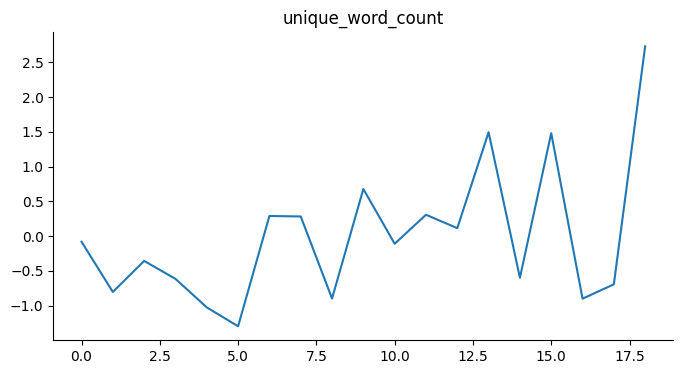

In [30]:
from matplotlib import pyplot as plt
_df_19['unique_word_count'].plot(kind='line', figsize=(8, 4), title='unique_word_count')
plt.gca().spines[['top', 'right']].set_visible(False)

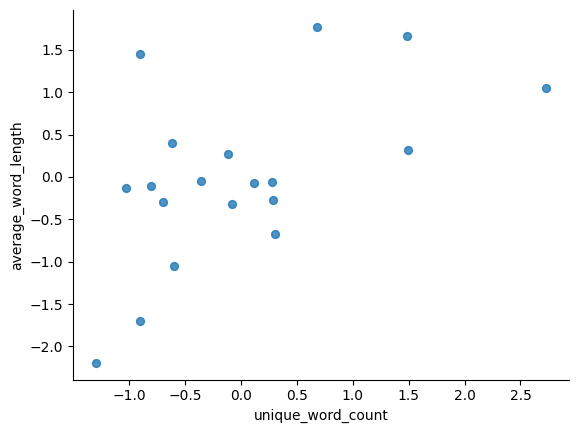

In [29]:
# @title unique_word_count vs average_word_length

from matplotlib import pyplot as plt
df_features.plot(kind='scatter', x='unique_word_count', y='average_word_length', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

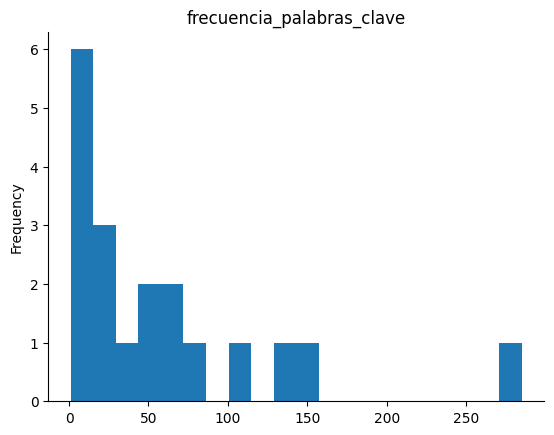

In [27]:
# @title frecuencia_palabras_clave

from matplotlib import pyplot as plt
df_features['frecuencia_palabras_clave'].plot(kind='hist', bins=20, title='frecuencia_palabras_clave')
plt.gca().spines[['top', 'right',]].set_visible(False)

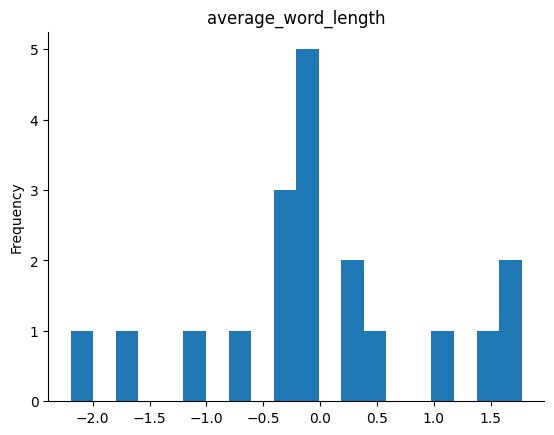

In [28]:
from matplotlib import pyplot as plt
_df_2['average_word_length'].plot(kind='hist', bins=20, title='average_word_length')
plt.gca().spines[['top', 'right',]].set_visible(False)

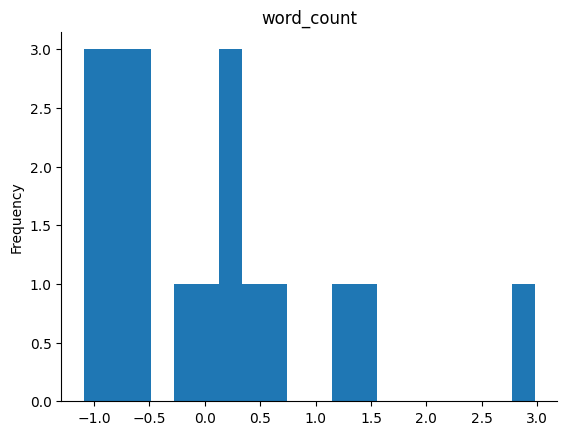

In [26]:
from matplotlib import pyplot as plt
_df_0['word_count'].plot(kind='hist', bins=20, title='word_count')
plt.gca().spines[['top', 'right',]].set_visible(False)